## Cummins - IT Data Analyst Activity

In [3]:
# Importing packages for my analysis
import pyodbc
import pandas as pd
import numpy as np
from numpy import median
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Filter FutureWarning related to category dtype
warnings.filterwarnings("ignore", category=FutureWarning)

#### Function definitions

##### Database connection

In [9]:
# Define the function to connect to the AdventureWorks 2022 database
def connect_to_sql_server():
    # Create a connection string
    db_server  = "localhost"
    db_database  = "AdventureWorks2022"
    
    connection_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={db_server};"
        f"DATABASE={db_database};"
        "Trusted_Connection=yes;"
    )
    
    # Connect to the database
    try:
        connection = pyodbc.connect(connection_string)
        return connection
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

##### Fetch Dataset

In [12]:
def query_to_dataframe(connection, query):
    
    """
    Execute a query using the given cursor and return the results as a DataFrame.
    The cursor is closed within the function.
    
    Parameters:
    connection (pyodbc.Connection): The database connection.
    query (str): The SQL query to execute.
    
    Returns:
    pd.DataFrame: The result of the query as a DataFrame.
    """
    
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        
        # Fetch the data and the column names
        data = cursor.fetchall()
        columns=[desc[0] for desc in cursor.description]

        # Convert to DataFrame
        df = pd.DataFrame.from_records(data, columns=columns)
        # Close the connection after usage
        connection.close()
        
        return df
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

### 1 Merge the sales and product datasets to create a comprehensive dataset for analysis

In [15]:
# Call the connect_to_sql_server function
connection = connect_to_sql_server()

#query to be used
query = '''
SELECT 
    soh.SalesOrderID AS 'Transaction ID', 
    soh.OrderDate AS 'Date of Sale', 
    soh.OnlineOrderFlag AS 'Store Location', 
    soh.CreditCardID, soh.SubTotal, soh.TaxAmt, soh.Freight, soh.TotalDue AS 'Sales Amount',
    sod.ProductID AS 'Product ID', 
    p.Name AS 'Product Name',
    p.ProductSubcategoryID, p.SellStartDate AS 'Launch Date',
    psc.ProductCategoryID, pc.Name AS 'Product Category',
    pcc.BusinessEntityID, ic.CountryRegionName AS 'Customer Region',
    pd.Gender AS 'Customer Gender',
    DATEDIFF(YEAR, pd.BirthDate, GETDATE()) - 
    CASE 
        WHEN MONTH(pd.BirthDate) > MONTH(GETDATE()) 
             OR (MONTH(pd.BirthDate) = MONTH(GETDATE()) AND DAY(pd.BirthDate) > DAY(GETDATE())) 
        THEN 1 
        ELSE 0 
    END AS 'Customer Age'
FROM [AdventureWorks2022].[Sales].[SalesOrderHeader] soh
LEFT JOIN [AdventureWorks2022].[Sales].[SalesOrderDetail] sod ON soh.SalesOrderID = sod.SalesOrderID
LEFT JOIN [AdventureWorks2022].[Production].[Product] p ON sod.ProductID = p.ProductID
LEFT JOIN [AdventureWorks2022].[Production].[ProductSubcategory] psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
LEFT JOIN [AdventureWorks2022].[Production].[ProductCategory] pc ON psc.ProductCategoryID = pc.ProductCategoryID
LEFT JOIN [AdventureWorks2022].[Sales].[PersonCreditCard] pcc ON soh.CreditCardID = pcc.CreditCardID
LEFT JOIN [AdventureWorks2022].[Sales].[vIndividualCustomer] ic ON pcc.BusinessEntityID = ic.BusinessEntityID
LEFT JOIN [AdventureWorks2022].[Sales].[vPersonDemographics] pd ON pcc.BusinessEntityID = pd.BusinessEntityID;
'''

# Call the function and get the DataFrame
df = query_to_dataframe(connection, query)

# Display the dataset
df.head()

,Transaction ID,Date of Sale,Store Location,CreditCardID,SubTotal,TaxAmt,Freight,Sales Amount,Product ID,Product Name,ProductSubcategoryID,Launch Date,ProductCategoryID,Product Category,BusinessEntityID,Customer Region,Customer Gender,Customer Age
0,43665,2011-05-31,False,15232.0,14352.7713,1375.9427,429.9821,16158.6961,707,"Sport-100 Helmet, Red",31,2011-05-31,4,Accessories,517.0,None,None,NaN
1,43668,2011-05-31,False,1566.0,35944.1562,3461.7654,1081.8017,40487.7233,707,"Sport-100 Helmet, Red",31,2011-05-31,4,Accessories,591.0,None,None,NaN
2,43673,2011-05-31,False,1417.0,3746.2015,357.9614,111.8629,4216.0258,707,"Sport-100 Helmet, Red",31,2011-05-31,4,Accessories,1085.0,None,None,NaN
3,43677,2011-05-31,False,14030.0,7793.1108,747.1011,233.4691,8773.6810,707,"Sport-100 Helmet, Red",31,2011-05-31,4,Accessories,1043.0,None,None,NaN
4,43678,2011-05-31,False,5093.0,9799.9243,942.0740,294.3981,11036.3964,707,"Sport-100 Helmet, Red",31,2011-05-31,4,Accessories,1183.0,None,None,NaN


### 1 Handling null values

CreditCardID and Business Entity ID has 2573 missing values. As it represents only 2.1% of all data - those rows will be dropped

In [20]:
# Drop rows where either 'CreditCardID' or 'BusinessEntityID' is null
dropped = df.dropna(subset=['CreditCardID', 'BusinessEntityID'])
dropped.isnull().sum()

Transaction ID              0
Date of Sale                0
Store Location              0
CreditCardID                0
SubTotal                    0
TaxAmt                      0
Freight                     0
Sales Amount                0
Product ID                  0
Product Name                0
ProductSubcategoryID        0
Launch Date                 0
ProductCategoryID           0
Product Category            0
BusinessEntityID            0
Customer Region         60791
Customer Gender         60791
Customer Age            60791
dtype: int64

Remaining 60791 null values belong to columns under Customer Demographics. For analysis purposes the dataset will be splitt in 2. The main DataFrame will contain data from all other columns except the 3 for Customer Demographics. The second DataFrame will contains all columns but the 60791 null values will be dropped in order to allow for comparison of Customer Demographics.

In [23]:
# Create a DataFrame with all rows excluding the 3 Customer columns with null values
clean = dropped.drop(columns=['Customer Region', 'Customer Gender', 'Customer Age'])
# Create a DataFrame with all columns but null values dropped
demo = dropped.dropna(subset=['Customer Region', 'Customer Gender', 'Customer Age'])
print(clean.info())
print(demo.info())

<class 'pandas.core.frame.DataFrame'>
Index: 118794 entries, 0 to 121366
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Transaction ID        118794 non-null  int64         
 1   Date of Sale          118794 non-null  datetime64[ns]
 2   Store Location        118794 non-null  bool          
 3   CreditCardID          118794 non-null  float64       
 4   SubTotal              118794 non-null  object        
 5   TaxAmt                118794 non-null  object        
 6   Freight               118794 non-null  object        
 7   Sales Amount          118794 non-null  object        
 8   Product ID            118794 non-null  int64         
 9   Product Name          118794 non-null  object        
 10  ProductSubcategoryID  118794 non-null  int64         
 11  Launch Date           118794 non-null  datetime64[ns]
 12  ProductCategoryID     118794 non-null  int64         
 13  Prod

#### Convert datatypes

In [26]:
# Remove non-numeric characters and convert to numeric
clean['SubTotal'] = pd.to_numeric(clean['SubTotal'], errors='coerce').fillna(0).astype(int)
clean['TaxAmt'] = pd.to_numeric(clean['TaxAmt'], errors='coerce').fillna(0).astype(int)
clean['Freight'] = pd.to_numeric(clean['Freight'], errors='coerce').fillna(0).astype(int)
clean['Sales Amount'] = pd.to_numeric(clean['Sales Amount'], errors='coerce').fillna(0).astype(int)
# Display the cleaned DataFrame
clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118794 entries, 0 to 121366
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Transaction ID        118794 non-null  int64         
 1   Date of Sale          118794 non-null  datetime64[ns]
 2   Store Location        118794 non-null  bool          
 3   CreditCardID          118794 non-null  float64       
 4   SubTotal              118794 non-null  int32         
 5   TaxAmt                118794 non-null  int32         
 6   Freight               118794 non-null  int32         
 7   Sales Amount          118794 non-null  int32         
 8   Product ID            118794 non-null  int64         
 9   Product Name          118794 non-null  object        
 10  ProductSubcategoryID  118794 non-null  int64         
 11  Launch Date           118794 non-null  datetime64[ns]
 12  ProductCategoryID     118794 non-null  int64         
 13  Prod

### 2 Calculate total sales for each product category

In [29]:
# Group by Product Category and sum the Sales Amount 
total_sales_by_category = clean.groupby('Product Category')['Sales Amount'].sum().reset_index()
# Sort the DataFrame by 'Sales Amount' in descending order
total_sales_by_category = total_sales_by_category.sort_values(by='Sales Amount', ascending=False)
total_sales_by_category

,Product Category,Sales Amount
1,Bikes,1187367231
3,Components,929332238
2,Clothing,540652740
0,Accessories,262514132


### 2 Identify the top-performing products

In [32]:
# Group by 'Product Name' and sum the 'Sales Amount'
total_sales_by_product = clean.groupby('Product Name')['Sales Amount'].sum().reset_index()
# Sort the DataFrame by 'Sales Amount' in descending order to find top-performing products
top_products = total_sales_by_product.sort_values(by='Sales Amount', ascending=False)
# Display the top 10 products
top_products.head(5)

,Product Name,Sales Amount
0,AWC Logo Cap,49576397
103,"Long-Sleeve Logo Jersey, L",47561822
232,"Sport-100 Helmet, Blue",46064710
231,"Sport-100 Helmet, Black",44758573
233,"Sport-100 Helmet, Red",43065576


### 2 Analyse sales trends over the six-month period

In [37]:
# Create a new column 'Year-Month' based on the 'Date of Sale' column
clean['YearMonth'] = clean['Date of Sale'].dt.to_period('M')
# Group by 'Year-Month' and sum 'Sales Amount', then reset index to keep 'Year-Month' as a column
monthly_sales = clean.groupby('YearMonth')['Sales Amount'].sum().reset_index()
# Sort the DataFrame by 'Sales Amount' in descending order
monthly_sales = monthly_sales.sort_values(by='YearMonth', ascending=False)
monthly_sales.iloc[1:7]

,YearMonth,Sales Amount
36,2014-05,135156759
35,2014-04,5330806
34,2014-03,214847026
33,2014-02,3888899
32,2014-01,80066967
31,2013-12,79349499


### 2 Compare online and physical store sales performance

In [40]:
# Group by 'Store Location' and sum the 'Sales Amount' for each location type
store_performance = clean.groupby('Store Location')['Sales Amount'].sum().reset_index()
# Rename the 'Store Location' values for readability
store_performance['Store Location'] = store_performance['Store Location'].map({False: 'Physical Store', True: 'Online Store'})
# Sort values in descending order of sales amount
store_performance = store_performance.sort_values(by='Sales Amount', ascending=False)
store_performance

,Store Location,Sales Amount
0,Physical Store,2857077250
1,Online Store,62789091


### 3 Bar charts for total sales by product category

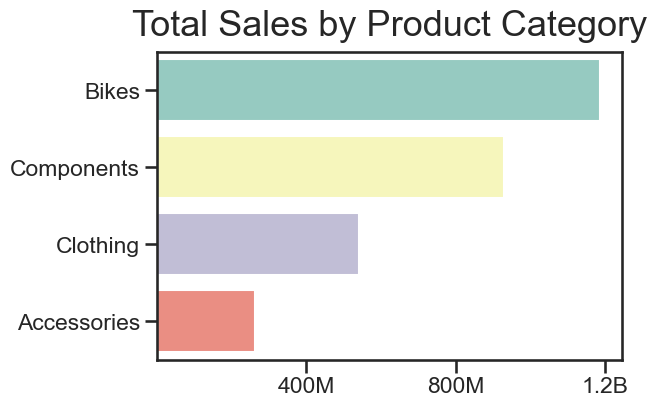

In [45]:
# Set the theme
sns.set_theme(context='talk', style='ticks', palette='Set3', font='sans-serif', color_codes=True)
# Create the horizontal bar plot
plt.figure(figsize=(6, 4))
g = sns.barplot(x='Sales Amount', y='Product Category', hue='Product Category', data=total_sales_by_category, orient='h', legend= False)
# Customize the plot
g.set_title('Total Sales by Product Category', fontsize=26, y=1.025)
plt.xlabel('')
plt.ylabel('') 
xtick_positions = [400000000, 800000000, 1200000000] 
xtick_labels = ['400M', '800M', '1.2B']
g.set_xticks(xtick_positions)
g.set_xticklabels(xtick_labels)
plt.show()

### 3 Line chart for sales trend over time

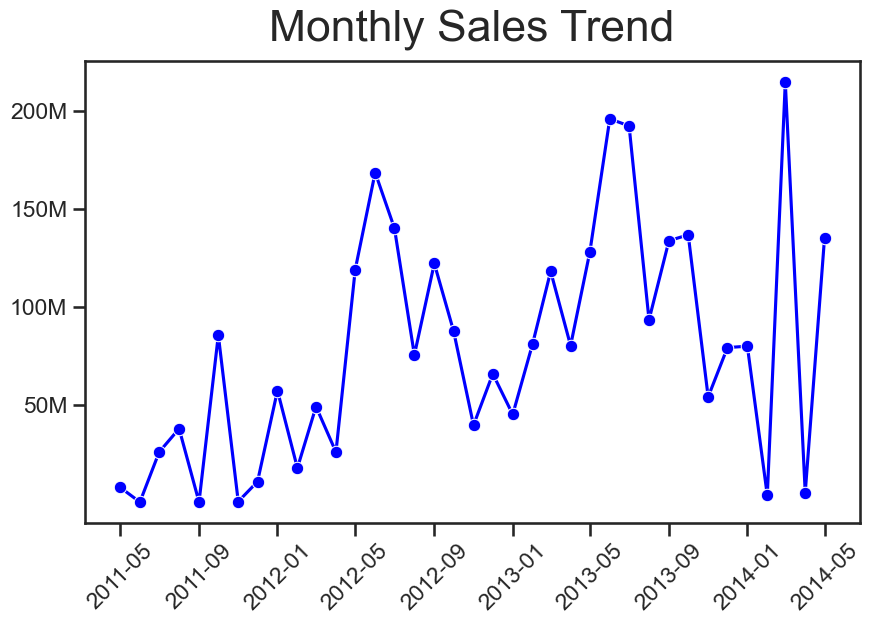

In [48]:
# Convert 'YearMonth' from Period to Timestamp
data = monthly_sales.iloc[1:].copy()
data['YearMonth'] = data['YearMonth'].dt.to_timestamp()
# Set the theme
sns.set_theme(context='talk', style='ticks', palette='Set3', font='sans-serif', color_codes=True)
# Set up the figure size
plt.figure(figsize=(10, 6))
# Create the line plot
g =sns.lineplot(data=data, x='YearMonth', y='Sales Amount', marker='o', color='blue')
# Add titles and labels
plt.title('Monthly Sales Trend', fontsize=32, y=1.025)
plt.xlabel('')
plt.ylabel('')
ytick_positions = [50000000, 100000000, 150000000, 200000000] 
ytick_labels = ['50M', '100M', '150M', '200M']
g.set_yticks(ytick_positions)
g.set_yticklabels(ytick_labels)
plt.xticks(rotation=45)
# Display the plot
plt.show()

### 3 Sales Distribution Online vs Physical Stores

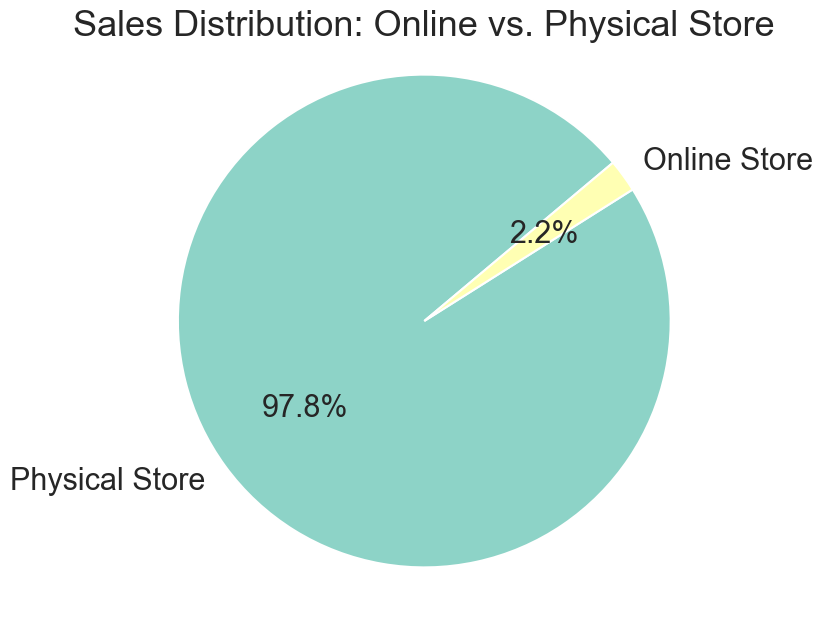

In [54]:
# Data preparation
labels = store_performance['Store Location']
sizes = store_performance['Sales Amount']
colors = sns.color_palette('Set3')[0:2]  
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%', 
        startangle=40,
        textprops={'fontsize': 22})
# Add a title
plt.title('Sales Distribution: Online vs. Physical Store',
          fontsize=26,
          y=0.95)
# Display the chart
plt.show()